# Vaccine Tweets Geological Data Exploration And Sentiment Statistics

* Authors: 
    * Yueshuwei Wu
* Description:
    * This time's data exploration analysis will focus on the geological distribution of the tweets we have. We first used the geotext library to extract user's geographical inofrmation from provided descriptions. Based on the distribution of users' locations, we picked some cities and countries to furthur study the user approval (in a certain region) of the COVID vaccine based on their tweet contents. For this stage of study, we will use the sentiment score of the tweet text as a measure of approval. The higher the sentiment score is, the higher the acceptance.
    * The first half of this note book is recycling code from the past assginments. For scentiment analysis, roll halfway down this note book until you see the cell titled **<font size="4">Calculate sentiment score</font>**

## Importing Dataset From Kaggle

* Since this Pfizer Vaccine Tweets dataset is continually updating, we want to pull the dataset directly from Kaggle using the provided API.
* To use the Kaggle API, you need to do the following:
    * Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens.
    * Click on Create New API Token - It will download kaggle.json file on your machine.
    * now just put it in the location C:\Users\(your user name)\.kaggle.

In [2]:
# uncomment the next line if you are running this notebook on a local machine.
#!pip install kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile
api = KaggleApi()
api.authenticate()
api.dataset_download_files('gpreda/pfizer-vaccine-tweets')

# Access the dataset just download.
zf = ZipFile('pfizer-vaccine-tweets.zip')
#extracted data is saved in the same directory as notebook
zf.extractall() 
zf.close()

## Data pre-processing
### Import Tools

In [3]:
import pandas as pd

### Load the dataset, check variable names and amount of data points.

In [4]:
df_tweets = pd.read_csv('vaccination_tweets.csv',dtype={ 'user_location':str})
print(df_tweets.columns)
print(df_tweets.shape)

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')
(5041, 16)


### Cleaning
<br/> Now we drop the columns that we will not use for this assignment. This cell may be modified for future needs.

In [5]:
df_tweets.drop(columns=['user_description','hashtags'], inplace=True)
print(df_tweets.columns)
print(df_tweets.shape)

Index(['id', 'user_name', 'user_location', 'user_created', 'user_followers',
       'user_friends', 'user_favourites', 'user_verified', 'date', 'text',
       'source', 'retweets', 'favorites', 'is_retweet'],
      dtype='object')
(5041, 14)


## Extracting user's locations.
Some users had proveded descriptions about their location but not necessarily the exact address. We want to at least extract the city and country information of the user. To accomplish this task, we will us a library call Geotext.This library allow us to extract city name and country code without going through the NLP hassle. The geological information will be used to guide the direction of this research. 
### Import GeoText

In [6]:
!pip install geotext
from geotext import GeoText

### How GeoText works?

In [7]:
# must import the method in next line to extract keys from ordered dictionary
from collections import OrderedDict 
places1 = GeoText("my bed")
print(places1.cities)
# prints empty list []
places2 = GeoText("London is a great city")
print(places2.cities)
# prints ['London']
print(list(places2.country_mentions.keys())[0])
print("tada!")

[]
['London']
GB
tada!


To make full use of it, we need to import one more library

In [8]:
from collections import OrderedDict 
od = OrderedDict() 
od['a'] = 1
od['b'] = 2
od['c'] = 3
od['d'] = 4
print(od.keys())

odict_keys(['a', 'b', 'c', 'd'])


### Further cleaning
Since we cannot extract locations from numbers or null entries we should drop the rows that user_location is not string. It's okay to have empty string as location description, Geotext will figure it out. 
<br/> This cell is optional, you can specify the location description to be string when loading the dataset. But if the location description is not string, then that row is likely to cause error later.

In [9]:
indexes_to_drop = []
for index, row in df_tweets.iterrows():
    if type(row['user_location']) is not str:
        indexes_to_drop.append(df_tweets.index[index])
    
df_tweets.drop(indexes_to_drop, inplace=True)
df_tweets.shape

(3983, 14)

We lost about 1000 data points, but we still have about 3983 left.
### Finally, extracting location data
<br/>Next we will extract and assign the city names to the each data point.

In [10]:
from collections import OrderedDict 
user_city = []
user_country = []
for index, row in df_tweets.iterrows():
    if GeoText(row['user_location']).cities:
        user_city.append(GeoText(row['user_location']).cities[0])
        user_country.append(list(GeoText(row['user_location']).country_mentions.keys())[0])
    else:
        user_city.append('')
        user_country.append('')

df_tweets['user_city'] = user_city
df_tweets['user_country'] = user_country

## Analysis
### Number of tweets per location
We want to see which cities' users are more likely to tweet about the vaccines. This can be done by appling the value_count() method.

In [11]:
df_tweets['user_city'].value_counts().to_frame().head(10)

,user_city
,2007
London,188
Dubai,62
New York,51
Toronto,50
New Delhi,47
Mumbai,42
Cornwall,39
Glasgow,39
Watford,38


Repeat the same procedure for countries.

In [12]:
df_tweets['user_country'].value_counts().to_frame().head(10)

,user_country
,2007
US,775
GB,426
IN,169
CA,168
AE,70
IE,38
DE,34
ZA,29
PH,23



We can see that majority of tweets are from the United States (US) and the United Kingdom (GB). Another interesting observation is that more than one third of the UK tweets are from London, whereas the US tweets has a more "sparse" geographical distribution. The city that contributed most to the US tweets is New York, which contributed less than 10% of the US tweets. 
### User contributions
The next step is to check if any user contributed significantly to the total counts.

In [13]:
frequent_tweeters = df_tweets['user_name'].value_counts().head(15).to_frame().reset_index()
frequent_tweeters.columns = ['user_name', 'count']
frequent_tweeters.head(5)

,user_name,count
0,TheRag,49
1,Ian 3.5% #FBPE,37
2,Simon Hodes ⬅️2m➡️ 😷,30
3,Whtrslugcaviiersong#dontstayhomeandcatchcovid19,30
4,ILKHA,29


Now let's find out where are these user tweeting from so we can consider which cities will not be investigated.

In [14]:
cities = []
countries = []
for index, row in df_tweets.iterrows():
    if row['user_name'] in list(frequent_tweeters['user_name']):
        if row['user_city'] and row['user_country']:
            cities.append(row['user_city'])
            countries.append(row['user_country'])
pairs = {'city': cities , 'country': countries}
df = pd.DataFrame(pairs)
df.groupby('country')['city'].value_counts()

country  city    
AE       Dubai       13
CA       Cornwall    37
GB       Watford     30
         Glasgow     20
IN       Mumbai      13
Name: city, dtype: int64

We can see these users contributed the majority of tweets from Cornwall Watford and Glasgow. we may study more closely what are they tweeting later, but for now we will exclude these cities from our study.

### What to investigate?
Notice US users contributed nearly one fifth of the tweets, we want to take a look at the cities that cares most about vaccine. We also want to see what makes them stand out and possible reasons behind this. Taking the information above in to consideration, we decided to further investigate the differences of race profiles amoung those top tweeted cities.

We firts seperate the US users from the dataset. we should have 717 data points.

In [15]:
df_UStweets = df_tweets.query("user_country == 'US'")
df_UStweets.shape

(775, 16)

Now we want to pick the cities we want to study, a value count will help us make our decision.

In [16]:
df_UStweets['user_city'].value_counts().to_frame().head(6)

,user_city
New York,50
Chicago,31
Boston,23
Atlanta,23
Los Angeles,21
Washington,20


We observed that New York city and Chicago city has signifant more tweets than others. The rest of the cities on the list seems all have tweets around 20. Thus, for simplicity, we will analyze the race profiles of New York, Chicago and Los Angeles. This will be done by introducing the census data.	

## Calculate sentiment score
For this stage of study, we will use the sentiment score of the tweets' text as a measure of approval. 
The higher the sentiment score of a tweet, the higher the acceptance.

We need to import the NLTK library and download some dictionaries to run certain methods.

In [17]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Wuyue\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Wuyue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Wuyue\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Now we will calculate the centiment score for each tweet, we will also split out the words for word frequency count and visualize it with word cloud.

In [25]:
# set stop words
stop_words = set(stopwords.words('english'))

# create new list for adding new columns
tweet_NPL=[]
sentiment = []

# load the sentiment function
sia = SentimentIntensityAnalyzer()
# load the stemmer function 
porter = nltk.PorterStemmer()

# iterate through all rows and calcukate sentiment scores
for index, row in df_tweets.iterrows():
    
    # we replace the URL to avoid unwanted clicking
    # not doing this will result most sentiment scores become 0, so be carefull
    tweet = row['text'].replace("://", "//")
    # the sentiment score is calculated by one line of code
    # it returns a disctionary, so we need to name the score we want
    sentiment.append(sia.polarity_scores(tweet)['compound'])
    # uncomment the following line, you will see the dictionary
    # sentiment.append(sia.polarity_scores(tweet))
    
    
    
    # now we need to extract usefull words from the text, it takes some steps
    # we first splits up the sentence into words using the tokenize function
    word_lists = word_tokenize(row['text'])
    # we then turn every word into lower case
    word_lists = [w.lower() for w in word_lists]
    
    # similar to stop words, we create a list of characters we don't want
    unwanted_chars = ['.',':',',',"n't","'ve",'http']
    
    # trim the word list using stop words and unwanted_chars
    trimmed_word_list = [w for w in word_lists if not w in stop_words] 
    trimmed_word_list = [w for w in word_lists if not w in unwanted_chars] 
    # we also filter out the URL
    trimmed_word_list = [w for w in trimmed_word_list if not w[:2]== "//"] 
    
    # Now lets stem the words using the stemmer function we load earlier
    trimmed_word_list  = [porter.stem(w) for w in trimmed_word_list]
    # add it to the list we created
    tweet_NPL.append(trimmed_word_list)

# now we have new column variables for analysis
df_tweets['text_words'] = tweet_NPL
df_tweets['sentiment'] = sentiment

Let's do some simple checking...
The following cell will demonstrate how we processed the tweet.

In [26]:
# do some simple checking
print (df_tweets['text'][1])
print (tweet_NPL[1])
print (sentiment[1])

While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm
['while', 'the', 'world', 'ha', 'been', 'on', 'the', 'wrong', 'side', 'of', 'histori', 'thi', 'year', 'hope', 'the', 'biggest', 'vaccin', 'effort', 'we', 'ev…', 'http']
-0.1027


Now we can check the world's sentiment scores about the vaccine.

0.12745149384885782


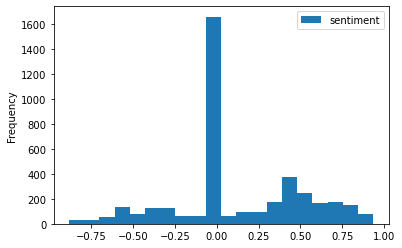

In [27]:
ax = df_tweets['sentiment'].plot.hist(stacked=True,bins=20)
print(df_tweets['sentiment'].mean())
ax.legend()

We can see most posts are neutral, and there are more positive posts than negative ones, which yields a positive average sentiment score. This is a good sign for puplic's acceptance of the vaccine.

Now let's take a look at the acceptance of individual cities.

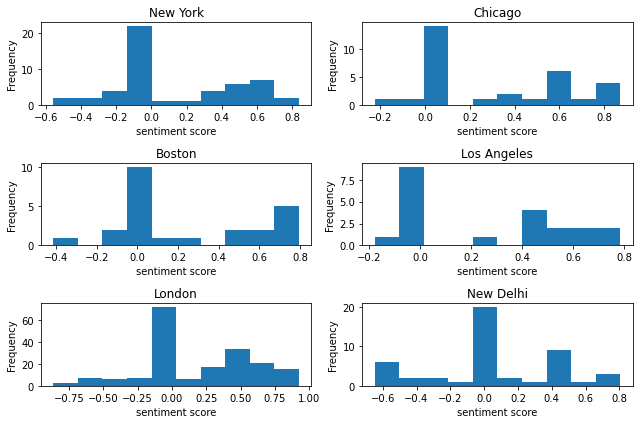

In [28]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,6))

# Divide the figure into a 1x2 grid, and give me the first section
# ax1 = fig.add_subplot(2, 2, (1,2))
ax1 = fig.add_subplot(3, 2, 1)
ax2 = fig.add_subplot(3, 2, 2)
ax3 = fig.add_subplot(3, 2, 3)
ax4 = fig.add_subplot(3, 2, 4)
ax5 = fig.add_subplot(3, 2, 5)
ax6 = fig.add_subplot(3, 2, 6)
axs = [ax1,ax2,ax3,ax4,ax5,ax6]
cities = ['New York','Chicago','Boston','Los Angeles','London','New Delhi']

for i in range(len(axs)):
    df_tweets.query("user_city == '"+ cities[i] + "'" )['sentiment'].plot.hist(stacked=True,bins=10, ax=axs[i])
    axs[i].set(xlabel='sentiment score', ylabel='Frequency', title=cities[i] )

plt.tight_layout()
plt.show()

The plots show that most people's reaction on the vaccine are either nuetral or positive.

Now let's compare the acceptance with other countries.

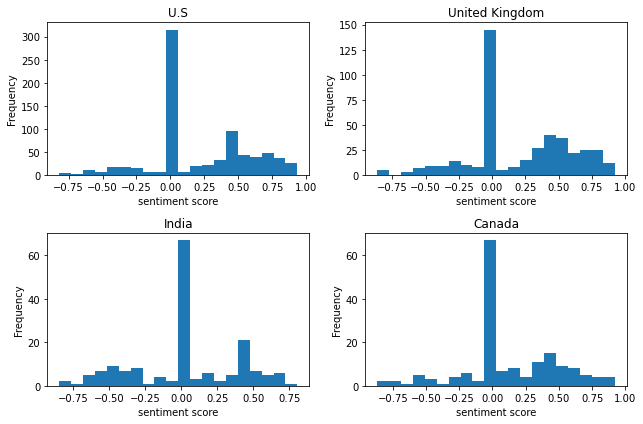

In [29]:
fig = plt.figure(figsize=(9,6))

# Divide the figure into a 1x2 grid, and give me the first section
# ax1 = fig.add_subplot(2, 2, (1,2))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
axs = [ax1,ax2,ax3,ax4]
contries = ['US','GB','IN','CA']
contries_full = ["U.S","United Kingdom","India","Canada"]

for i in range(len(axs)):
    df_tweets.query("user_country == '"+ contries[i] + "'" )['sentiment'].plot.hist(stacked=True,bins=20, ax=axs[i])
    axs[i].set(xlabel='sentiment score', ylabel='Frequency', title=contries_full[i] )

plt.tight_layout()
plt.show()

Both U.S and U.K have a high acceptance rate, which is as expected since we are all having a hard time. Interestingly India has a significant higher rejection rate (negative sentiment score) about the vaccine. This will need to be further investigated.